In [1]:
import time
from river.metrics import RMSE
from src.data import RunnerLog
from src.plot import Plots
from src.data import get_synth_datasets
from src.models import get_models

def evaluate(dataset, model, metric, print_every=10):
    """
    Executa a avaliação progressiva e captura métricas de performance e complexidade.
    Retorna dicionários com o histórico de cada métrica para plotagem.
    """
    dataset_name, dataset_stream = dataset.popitem()
    model_name, eval_model  = model.popitem()

    log = RunnerLog(
        model_name=model_name,
        dataset_name=dataset_name,
    )
    metric = metric.clone()
    print(f"Evaluating {model_name} on {dataset_name}")


    for i, (x, y) in enumerate(dataset_stream):
        # Medir tempo de inferência
        start_pred = time.perf_counter()
        y_pred = eval_model.predict_one(x)
        end_pred = time.perf_counter()

        metric.update(y, y_pred)

        # Medir tempo de aprendizagem
        start_learn = time.perf_counter()
        eval_model.learn_one(x, y)
        end_learn = time.perf_counter()

        if (i + 1) % print_every == 0:
            log.update(
                steps=i+1,
                performance=metric.get(),
                n_nodes=getattr(eval_model, 'n_nodes', 0),
                n_leaves=getattr(eval_model, "n_leaves", 0),
                height=getattr(eval_model, 'height', 0),
                inference_time=(end_pred - start_pred) * 1_000_000,
                learn_time=(end_learn - start_learn) * 1_000_000,
                memory_usage=getattr(eval_model, '_raw_memory_usage', 0)
            )
    print(f"Final {metric}: {metric.get():.6f}")
    print("-" * 50)
    return log

Evaluating HTR-QO (Multi-way) on friedman_drift_local
Final RMSE: 2.658697: 2.658697
--------------------------------------------------
Evaluating HTR-F-QO (α=0.999) on friedman_drift_local
Final RMSE: 2.536894: 2.536894
--------------------------------------------------
Evaluating HTR-F-QO (α=0.990) on friedman_drift_local
Final RMSE: 2.589722: 2.589722
--------------------------------------------------
Evaluating HTR-F-QO (α=0.900) on friedman_drift_local
Final RMSE: 2.529636: 2.529636
--------------------------------------------------
Evaluating HATR (Adaptive) on friedman_drift_local
Final RMSE: 2.609755: 2.609755
--------------------------------------------------
Evaluating HTR-QO (Multi-way) on hyperplane_drift
Final RMSE: 0.374025: 0.374025
--------------------------------------------------
Evaluating HTR-F-QO (α=0.999) on hyperplane_drift
Final RMSE: 0.372384: 0.372384
--------------------------------------------------
Evaluating HTR-F-QO (α=0.990) on hyperplane_drift
Final RMS

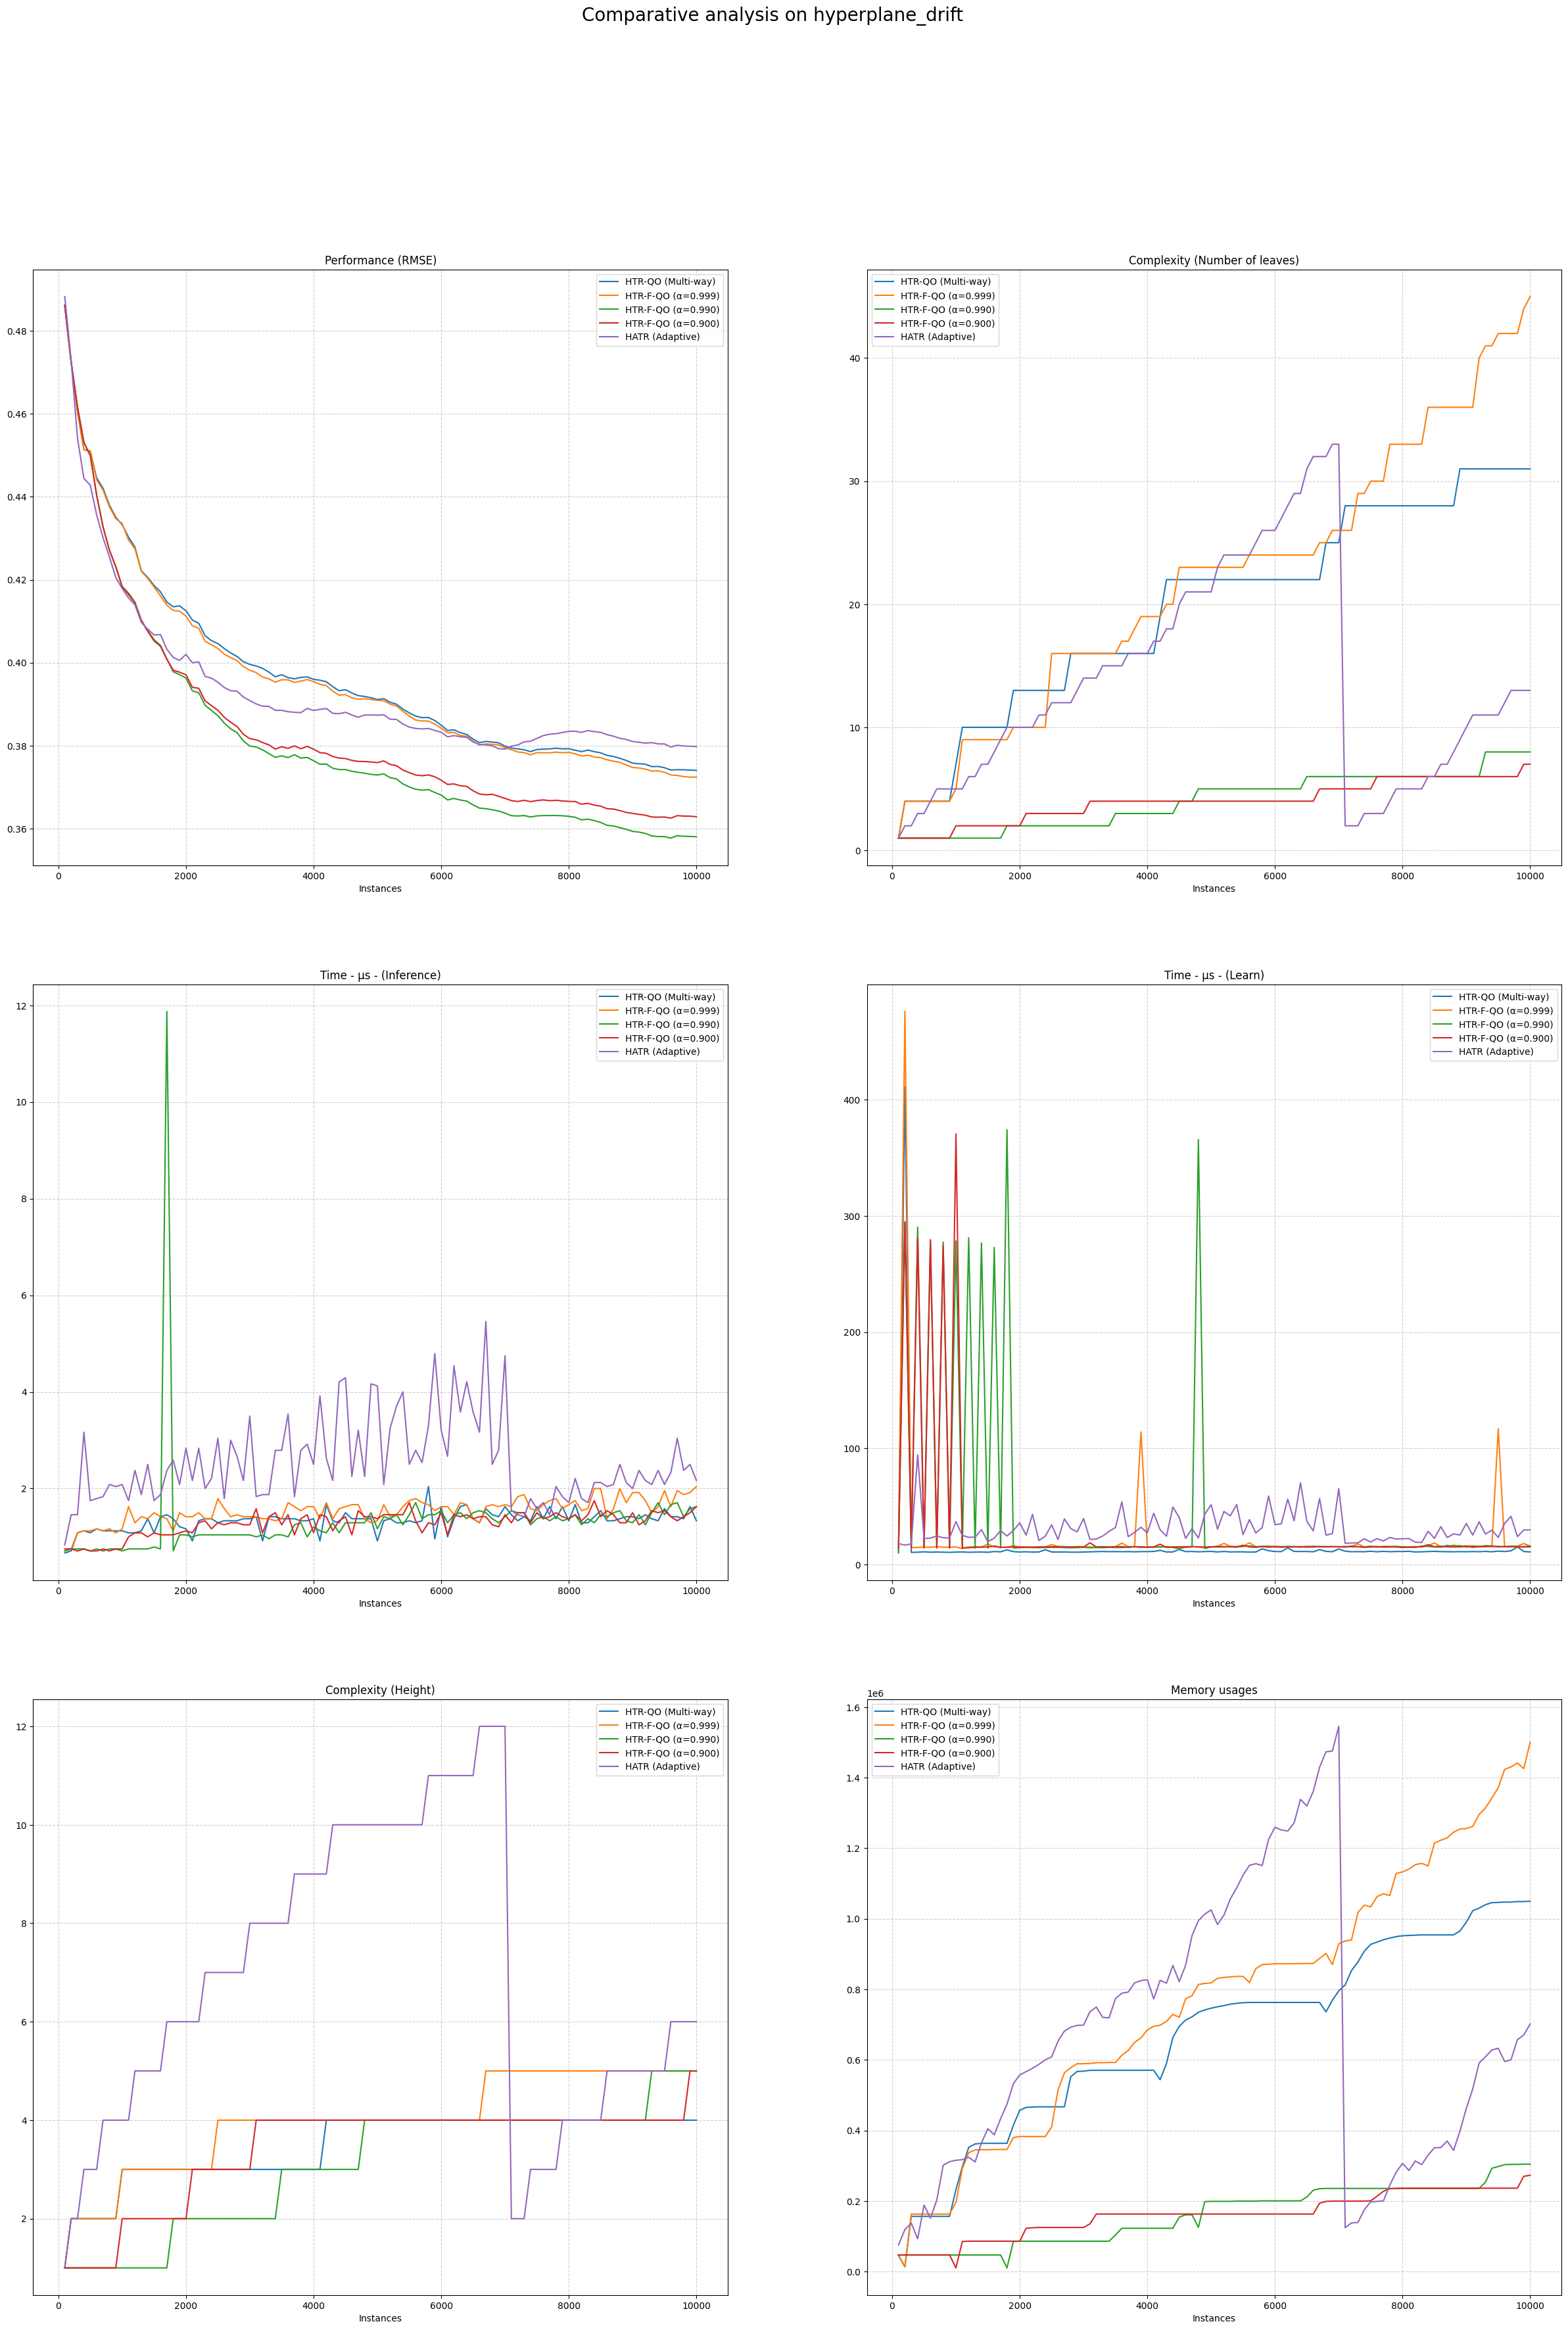

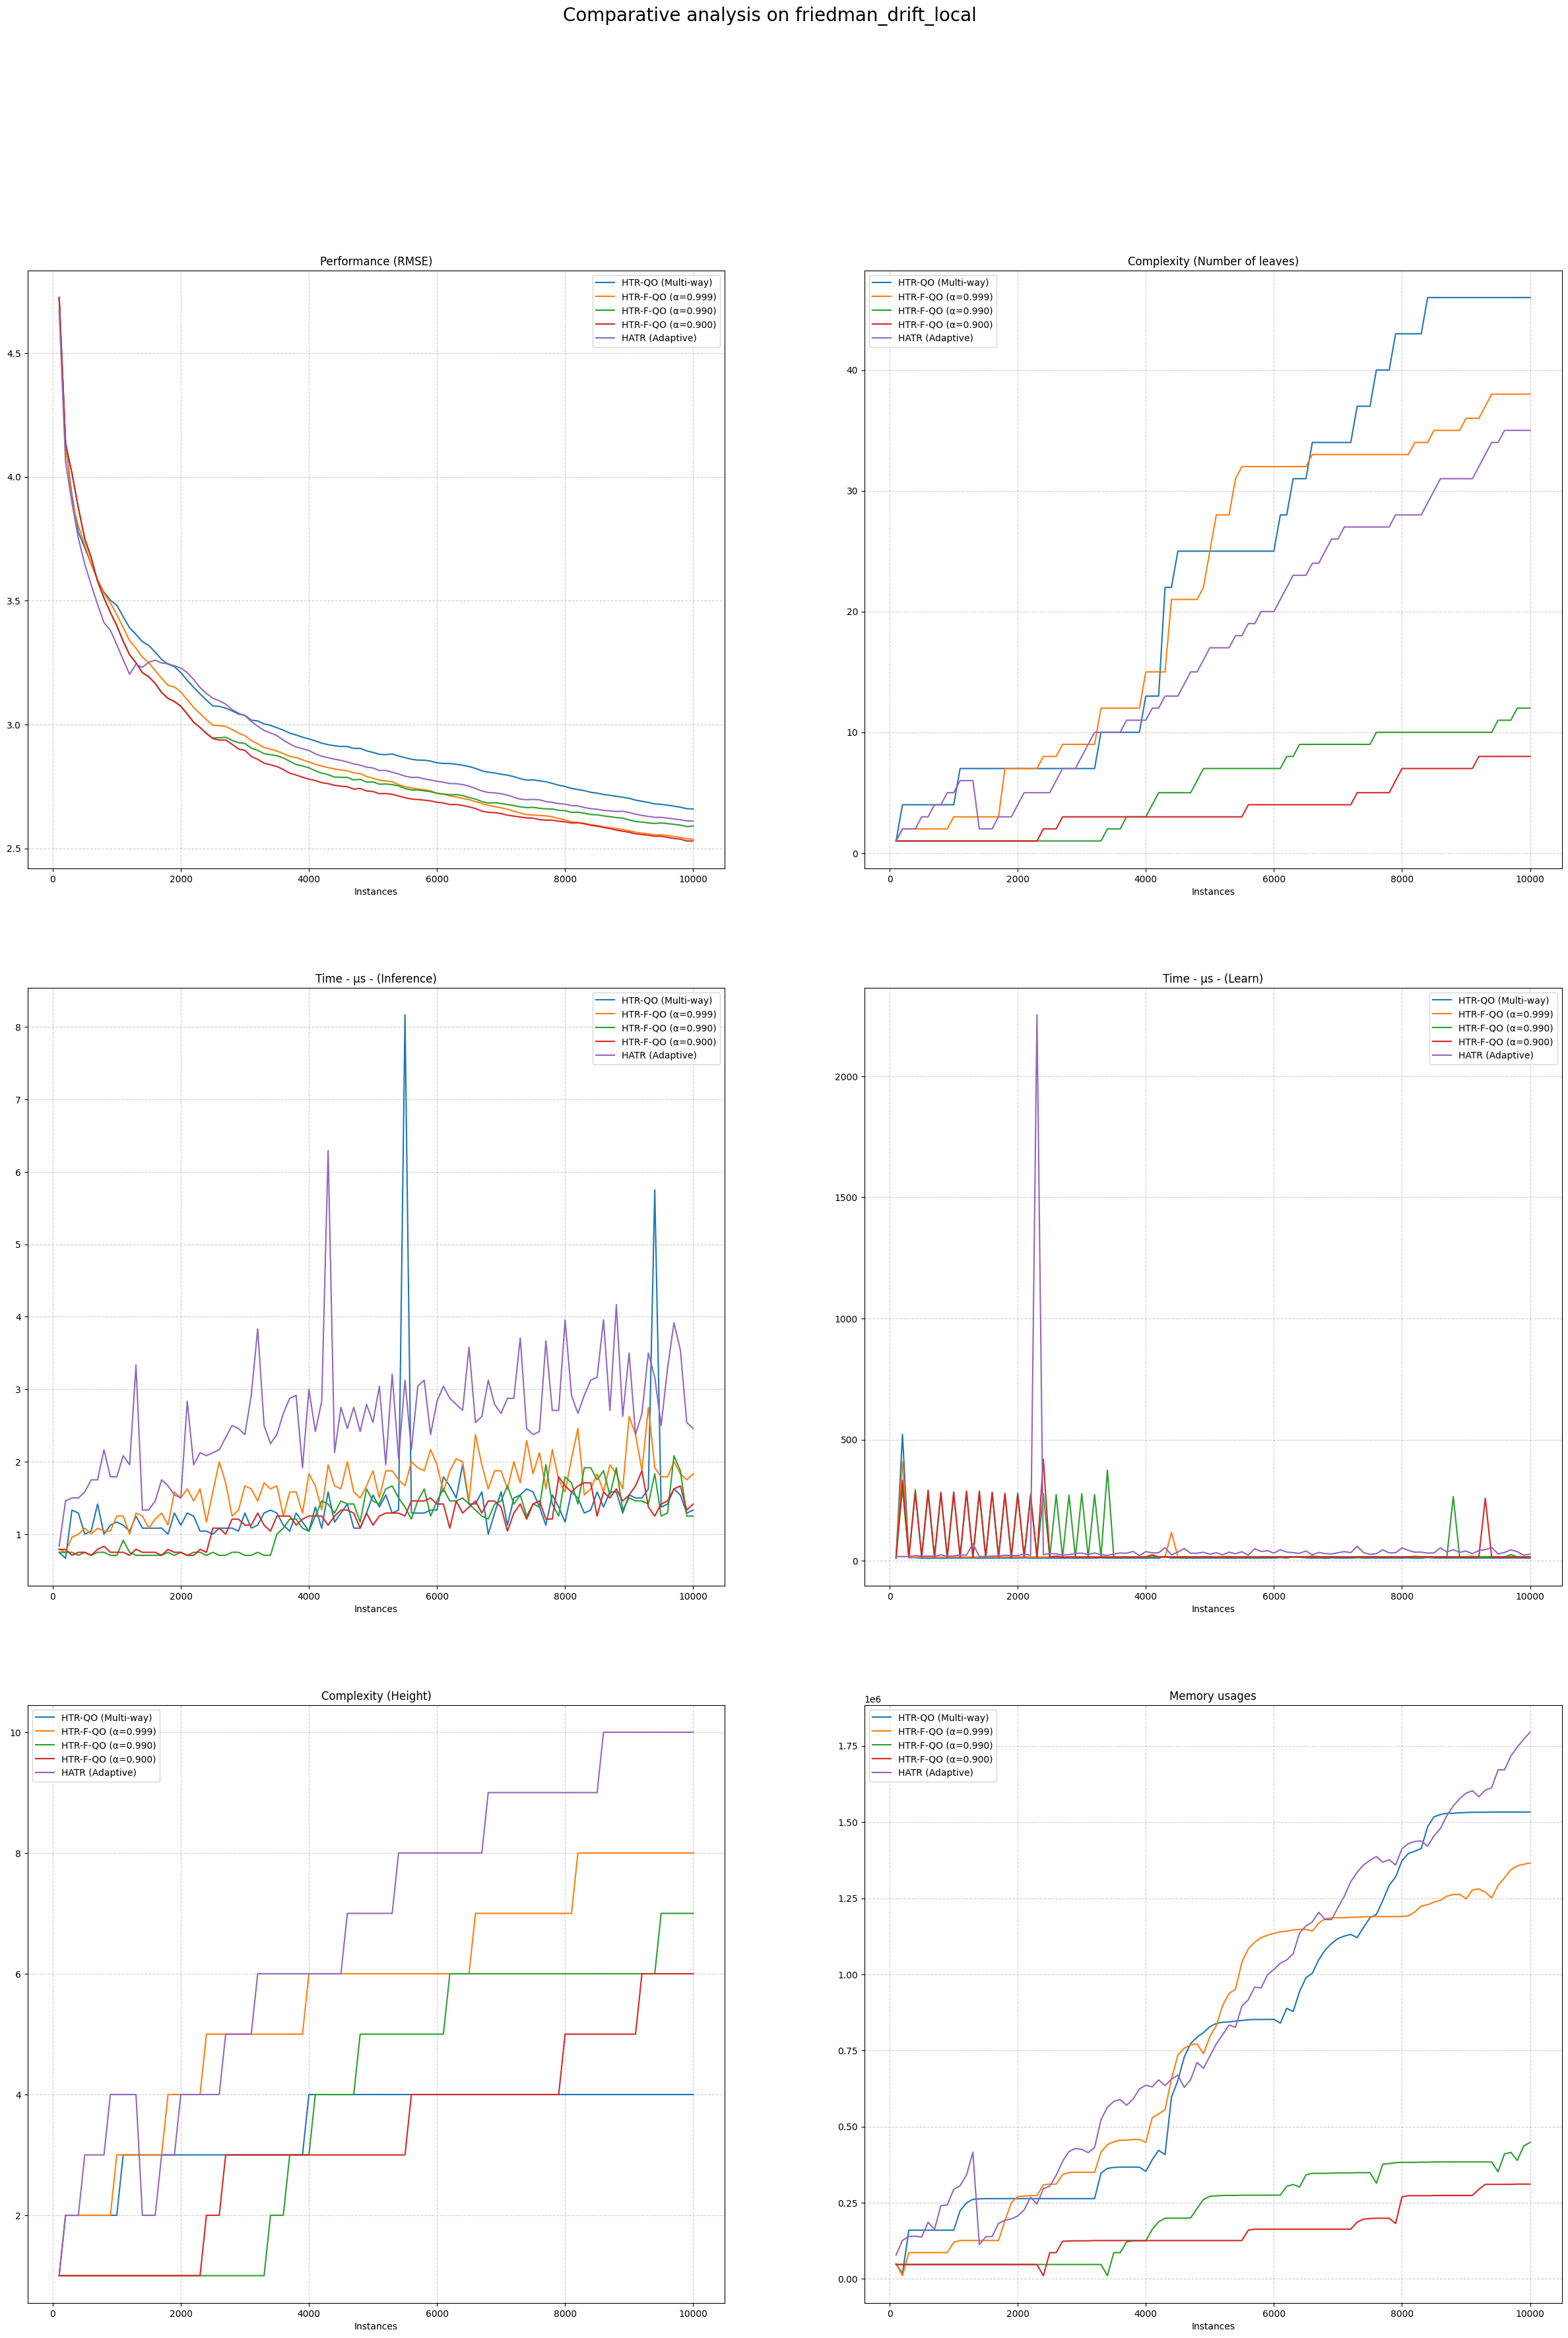

In [2]:
INSTANCES = 10_000
synth_datasets = get_synth_datasets()
models = get_models()
logs = []
for d_name, dataset_generator in synth_datasets.items():
    for model_name, model in models.items():
        eval_model = {
            model_name: model.clone()
        }
        eval_dataset_stream = {
            d_name: dataset_generator().take(INSTANCES)
        }
        logs.append(evaluate(
            eval_dataset_stream,
            eval_model,
            RMSE(),
            print_every=INSTANCES/100
        ))
plot_gen = Plots()
plot_gen.plot_all(logs)